### Tasks

#### figure out a way to make the model deeper 
#### consider small model as low rank representation and project higher. (using outer product) train only small number of outer product parameters - https://arxiv.org/pdf/2012.13255.pdf
#### study the difference between Llama 7B and 33B 

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader

import torchvision
import torchvision.transforms as transforms
from torchvision.utils import make_grid

In [5]:
import numpy as np
import pandas as pd

dataset = pd.read_csv("Data/SUSY.csv", header=None)

In [6]:
dataset

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18
0,0.0,0.972861,0.653855,1.176225,1.157156,-1.739873,-0.874309,0.567765,-0.175000,0.810061,-0.252552,1.921887,0.889637,0.410772,1.145621,1.932632,0.994464,1.367815,0.040714
1,1.0,1.667973,0.064191,-1.225171,0.506102,-0.338939,1.672543,3.475464,-1.219136,0.012955,3.775174,1.045977,0.568051,0.481928,0.000000,0.448410,0.205356,1.321893,0.377584
2,1.0,0.444840,-0.134298,-0.709972,0.451719,-1.613871,-0.768661,1.219918,0.504026,1.831248,-0.431385,0.526283,0.941514,1.587535,2.024308,0.603498,1.562374,1.135454,0.180910
3,1.0,0.381256,-0.976145,0.693152,0.448959,0.891753,-0.677328,2.033060,1.533041,3.046260,-1.005285,0.569386,1.015211,1.582217,1.551914,0.761215,1.715464,1.492257,0.090719
4,1.0,1.309996,-0.690089,-0.676259,1.589283,-0.693326,0.622907,1.087562,-0.381742,0.589204,1.365479,1.179295,0.968218,0.728563,0.000000,1.083158,0.043429,1.154854,0.094859
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4999995,1.0,0.853325,-0.961783,-1.487277,0.678190,0.493580,1.647969,1.843867,0.276954,1.025105,-1.486535,0.892879,1.684429,1.674084,3.366298,1.046707,2.646649,1.389226,0.364599
4999996,0.0,0.951581,0.139370,1.436884,0.880440,-0.351948,-0.740852,0.290863,-0.732360,0.001360,0.257738,0.802871,0.545319,0.602730,0.002998,0.748959,0.401166,0.443471,0.239953
4999997,0.0,0.840389,1.419162,-1.218766,1.195631,1.695645,0.663756,0.490888,-0.509186,0.704289,0.045744,0.825015,0.723530,0.778236,0.752942,0.838953,0.614048,1.210595,0.026692
4999998,1.0,1.784218,-0.833565,-0.560091,0.953342,-0.688969,-1.428233,2.660703,-0.861344,2.116892,2.906151,1.232334,0.952444,0.685846,0.000000,0.781874,0.676003,1.197807,0.093689


In [7]:
class SUSY(Dataset):
    def __init__(self, X, y):
        self.X = X
        self.y = y
        
    def __len__(self):
        return len(self.X)
    
    def __getitem__(self, index):
        return self.X[index], self.y[index]

In [8]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler  

X_train, X_valid, y_train, y_valid = \
    train_test_split(dataset.loc[:, 1:], dataset.loc[:, 0], test_size=1/6, random_state=42)

scaler = MinMaxScaler()
X_train = scaler.fit_transform(X_train)
X_valid = scaler.transform(X_valid)

X_train, y_train = np.array(X_train), np.array(y_train)
X_valid, y_valid = np.array(X_valid), np.array(y_valid)


print('X train shape : ', X_train.shape)
print('y train label shape : ', y_train.shape)
print('X valid  shape : ', X_valid.shape)
print('y valid shape: ', y_valid.shape)

X train shape :  (4166666, 18)
y train label shape :  (4166666,)
X valid  shape :  (833334, 18)
y valid shape:  (833334,)


In [10]:
train_dataset = SUSY(X = X_train, y= y_train)
val_dataset = SUSY(X = X_valid, y = y_valid)

train_loader = DataLoader(dataset=train_dataset, batch_size=128, shuffle=True)
val_loader = DataLoader(dataset=val_dataset, batch_size=128, shuffle=False)

In [11]:
dataiter = iter(train_loader)
X, y = next(dataiter)

print('X train shape on PyTorch : ', X.size())
print('y train shape on PyTorch : ', y.size())

X train shape on PyTorch :  torch.Size([128, 18])
y train shape on PyTorch :  torch.Size([128])


In [21]:
from livelossplot import PlotLosses
from collections import defaultdict
device = torch.device("cuda")

def train_model(batch_size, 
                n_epochs, 
                learningRate, 
                model, 
                cost_function, 
                optimizer,
                scheduler,
                train_loader,
                val_loader,
                name):

  # Move the model and cost function to GPU (if needed).
  model = model.to(device)
  cost_function = cost_function.to(device)

  # Keep track of best accuracy so far.
  best_accuracy = 0 
  liveloss = PlotLosses()
  recordlogs = defaultdict(list)

  # Main for loop of SGD.
  for epoch in range(0, n_epochs):
    logs = {}

    # initialize control variables.
    correct = 0
    cumulative_loss = 0
    n_samples = 0

    # Set the model in training mode.
    model.train()

    # Sample a batch on each iteration.
    for (batch_id, (xb, yb)) in enumerate(train_loader):
      model.zero_grad()
      # Move (x,y) data to GPU (if so desired).
      xb = xb.to(device)
      yb = yb.to(device)

      # Compute predictions.
      #print("debug", xb.shape, yb.shape)#, predicted.shape)
      predicted = model(xb.float()).squeeze()
      
      # Compute loss.
      loss = cost_function(predicted, yb)
      cumulative_loss += loss.item()

      # Compute gradients (autograd).
      loss.backward()
    
      # Count how many correct in batch.
      predicted_ = predicted.detach().sigmoid()
      predicted_ = torch.round(predicted_)
      correct += (predicted_ == yb).sum().cpu().item()
      n_samples += xb.size(0)

      # Run one basic training step of SGD.
      optimizer.step()
      # This does basically the following operation.
      # for param in model.parameters():
      #    param.data -= learningRate * param.grad.data

      # Keep track of loss and accuracy for the plot.
      n_batches = 1 + batch_id 
      logs['loss'] = cumulative_loss / n_batches
      logs['accuracy'] = correct / n_samples
    
    # initialize control variables.
    correct = 0
    cumulative_loss = 0
    n_samples = 0

    # Set the model in evaluation mode.
    model.eval()

    # No need to keep track of gradients for this part.
    with torch.no_grad():
      # Run the model on the validation set to keep track of accuracy there.
      for (batch_id, (xb, yb)) in enumerate(val_loader):

        # Move data to GPU if needed.
        xb = xb.to(device)
        yb = yb.to(device)
    
        # Compute predictions.
        predicted = model(xb.float()).squeeze()

        # Compute loss.
        loss = cost_function(predicted, yb)
        cumulative_loss += loss.item()
        
        # Count how many correct in batch.
        predicted_ = predicted.detach().sigmoid()
        predicted_ = torch.round(predicted_)
        correct += (predicted_ == yb).sum().cpu().item()
        n_samples += xb.size(0)

        # Keep track of loss and accuracy for the plot.
        n_batches = 1 + batch_id
        logs['val_loss'] = cumulative_loss / n_batches
        logs['val_accuracy'] = correct / n_samples

    # Save the parameters for the best accuracy on the validation set so far.
    if logs['val_accuracy'] > best_accuracy:
        best_accuracy = logs['val_accuracy']
        torch.save(model.state_dict(), 'checkpoints/best_model_so_far_' + name + '.pth')

    # Update the plot with new logging information.
    liveloss.update(logs)
    liveloss.send()
    
    recordlogs['loss'].append(logs['loss'])
    recordlogs['val_loss'].append(logs['loss'])
    recordlogs['accuracy'].append(logs['accuracy'])
    recordlogs['val_accuracy'].append(logs['val_accuracy'])

    # What is this for? Please look it up.
    if scheduler != -1:
        scheduler.step()
        
  return recordlogs
  # Load the model parameters for the one that achieved the best val accuracy.
  # model.load_state_dict(torch.load('best_model_so_far.pth'))    

### Check the performance of small-sized model

In [22]:
class MLPSmall(nn.Module):
    def __init__(self):
        super(MLPSmall, self).__init__()
        self.layers = nn.Sequential(
            nn.Linear(18, 256),
            nn.ReLU(),
            nn.Linear(256, 32),
            nn.ReLU(),
            nn.Linear(32, 1)
        )
        
    def forward(self, x):
        x = self.layers(x)
        return x

In [23]:
learningRate = 1e-4
modelSmall = MLPSmall()
optimizer = torch.optim.Adam(modelSmall.parameters(), lr=learningRate)
cost_function = nn.BCEWithLogitsLoss()
batch_size = 128
n_epochs = 20
print(modelSmall)

MLPSmall(
  (layers): Sequential(
    (0): Linear(in_features=18, out_features=256, bias=True)
    (1): ReLU()
    (2): Linear(in_features=256, out_features=32, bias=True)
    (3): ReLU()
    (4): Linear(in_features=32, out_features=1, bias=True)
  )
)


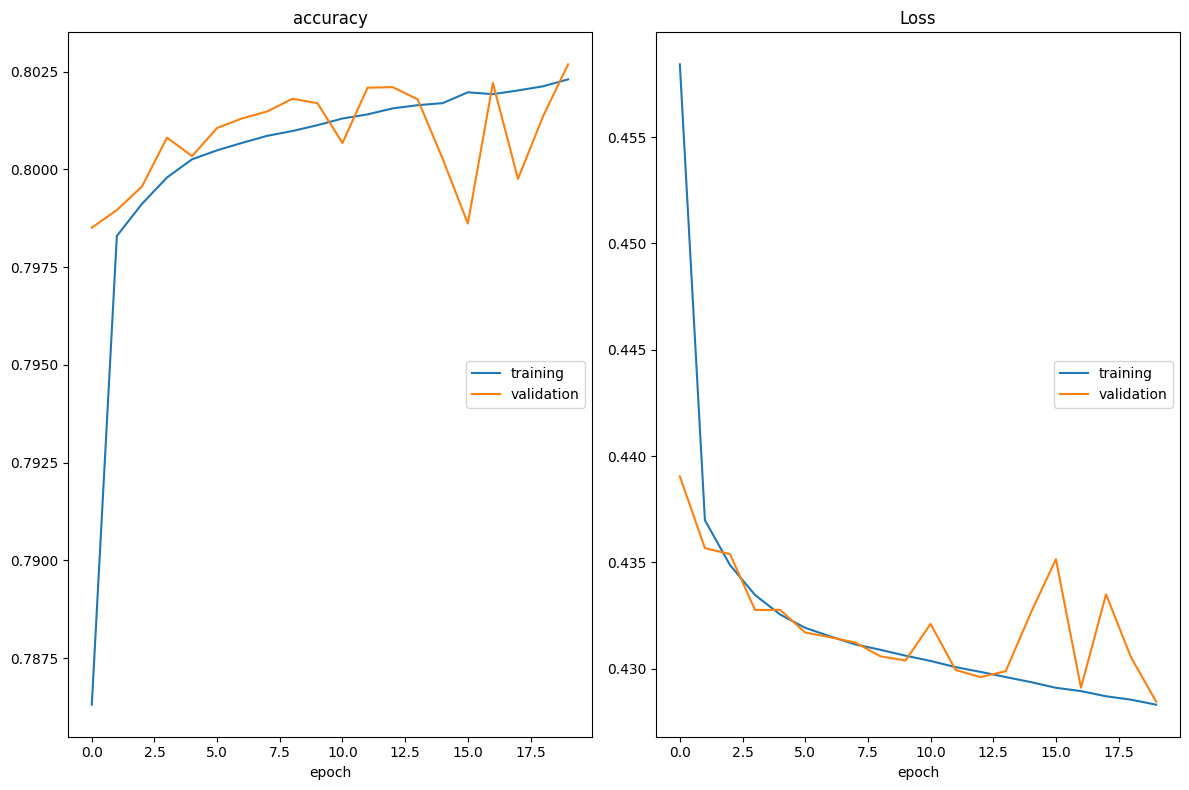

accuracy
	training         	 (min:    0.786, max:    0.802, cur:    0.802)
	validation       	 (min:    0.799, max:    0.803, cur:    0.803)
Loss
	training         	 (min:    0.428, max:    0.458, cur:    0.428)
	validation       	 (min:    0.428, max:    0.439, cur:    0.428)


In [24]:
small_logs = train_model(batch_size, n_epochs, learningRate, 
            modelSmall, cost_function, optimizer, -1, 
            train_loader, val_loader, name = 'small-SUSY');

### Check the performance of medium-sized model

In [28]:
class MLPMedium(nn.Module):
    def __init__(self):
        super(MLPMedium, self).__init__()
        self.layers = nn.Sequential(
            nn.Linear(18, 1024),
            nn.ReLU(),
            nn.Linear(1024, 256),
            nn.ReLU(),
            nn.Linear(256, 1)
        )
        
    def forward(self, x):
        x = self.layers(x)
        return x

In [29]:
learningRate = 1e-4
modelMedium = MLPMedium()
optimizer = torch.optim.Adam(modelMedium.parameters(), lr=learningRate)
cost_function = nn.BCEWithLogitsLoss()
batch_size = 128
n_epochs = 20
print(modelMedium)

MLPMedium(
  (layers): Sequential(
    (0): Linear(in_features=18, out_features=1024, bias=True)
    (1): ReLU()
    (2): Linear(in_features=1024, out_features=256, bias=True)
    (3): ReLU()
    (4): Linear(in_features=256, out_features=1, bias=True)
  )
)


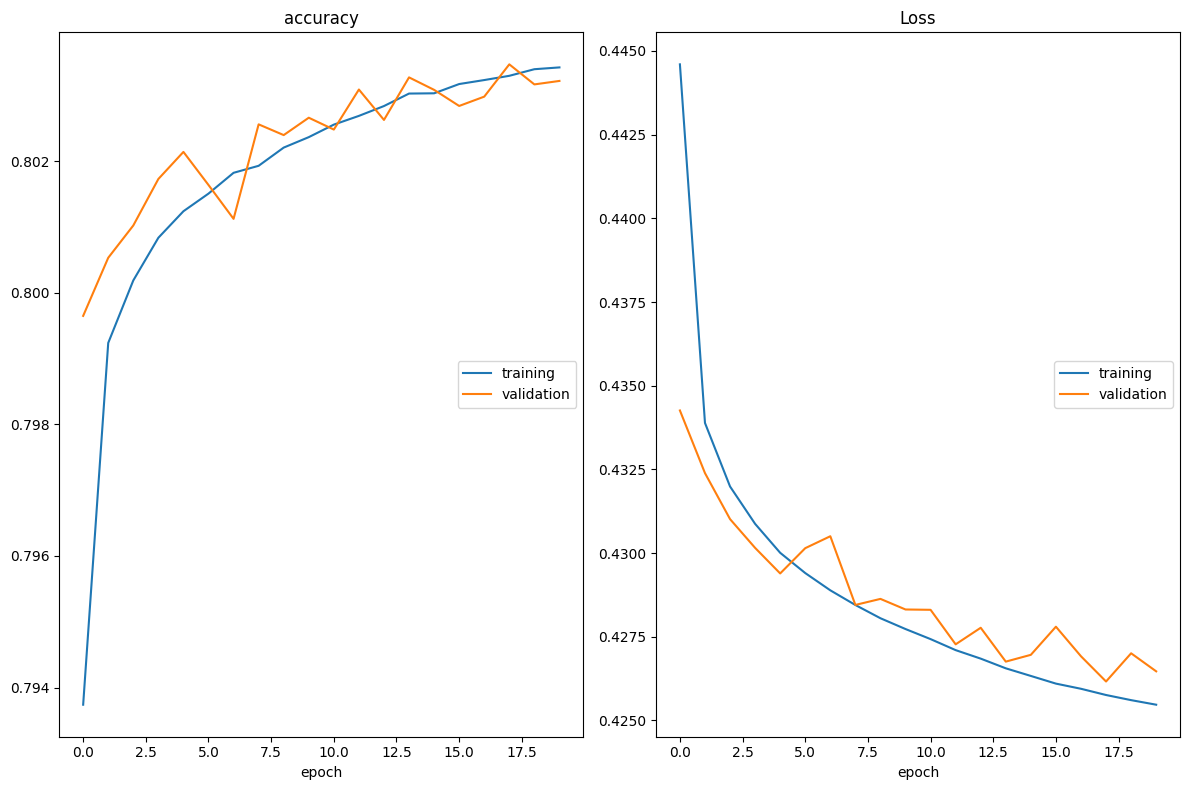

accuracy
	training         	 (min:    0.794, max:    0.803, cur:    0.803)
	validation       	 (min:    0.800, max:    0.803, cur:    0.803)
Loss
	training         	 (min:    0.425, max:    0.445, cur:    0.425)
	validation       	 (min:    0.426, max:    0.434, cur:    0.426)


In [30]:
medium_logs = train_model(batch_size, n_epochs, learningRate, 
            modelMedium, cost_function, optimizer, -1, 
            train_loader, val_loader, name = 'medium-SUSY');

### Densify small model to the same parameters as the medium model

In [33]:
from scipy.stats import ortho_group
class MLPSmalltoMedium(nn.Module):
    def __init__(self, modelSmall):
        super(MLPSmalltoMedium, self).__init__()
        # extract weights from modelSmall
        self.layers = nn.Sequential(
            nn.Linear(18, 1024),
            nn.ReLU(),
            nn.Linear(1024, 256),
            nn.ReLU(),
            nn.Linear(256, 1)
        )
        
        for layer in range(len(modelSmall.layers)):
            try:
                tempWeight =  modelSmall.layers[layer].weight.data
                if layer != len(modelSmall.layers) - 1:
                    left = torch.tensor(np.delete(ortho_group.rvs(self.layers[layer].out_features), np.s_[modelSmall.layers[layer].out_features:], 1), device=device, dtype=torch.float32)
#                     print("left: " + str(left.size()), "current: " + str(tempWeight.size()))
                    tempWeight = torch.matmul(left, tempWeight)
                if layer != 0:
                    right = torch.tensor(np.delete(ortho_group.rvs(self.layers[layer].in_features), np.s_[modelSmall.layers[layer].in_features:], 1), device=device, dtype=torch.float32)
#                     print("current: " + str(tempWeight.size()), "right: " + str(right.T.size()))
                    tempWeight = torch.matmul(tempWeight, right.T)
                
                self.layers[layer].weight.data = tempWeight
                
            
            except Exception as e:
                print("Layer " + str(layer) + ": " + str(e))
                
        
    def forward(self, x):
        x = self.layers(x)
        return x

In [34]:
bestSmallModel = MLPSmall()
bestSmallModel.load_state_dict(torch.load('checkpoints/best_model_so_far_small-SUSY.pth'))
bestSmallModel = bestSmallModel.to(device)
upscaledModel = MLPSmalltoMedium(bestSmallModel)

Layer 1: 'ReLU' object has no attribute 'weight'
Layer 3: 'ReLU' object has no attribute 'weight'


In [35]:
learningRate = 1e-4
optimizer = torch.optim.Adam(upscaledModel.parameters(), lr=learningRate)
cost_function = nn.BCEWithLogitsLoss()
batch_size = 128
n_epochs = 20
print(upscaledModel)

MLPSmalltoMedium(
  (layers): Sequential(
    (0): Linear(in_features=18, out_features=1024, bias=True)
    (1): ReLU()
    (2): Linear(in_features=1024, out_features=256, bias=True)
    (3): ReLU()
    (4): Linear(in_features=256, out_features=1, bias=True)
  )
)


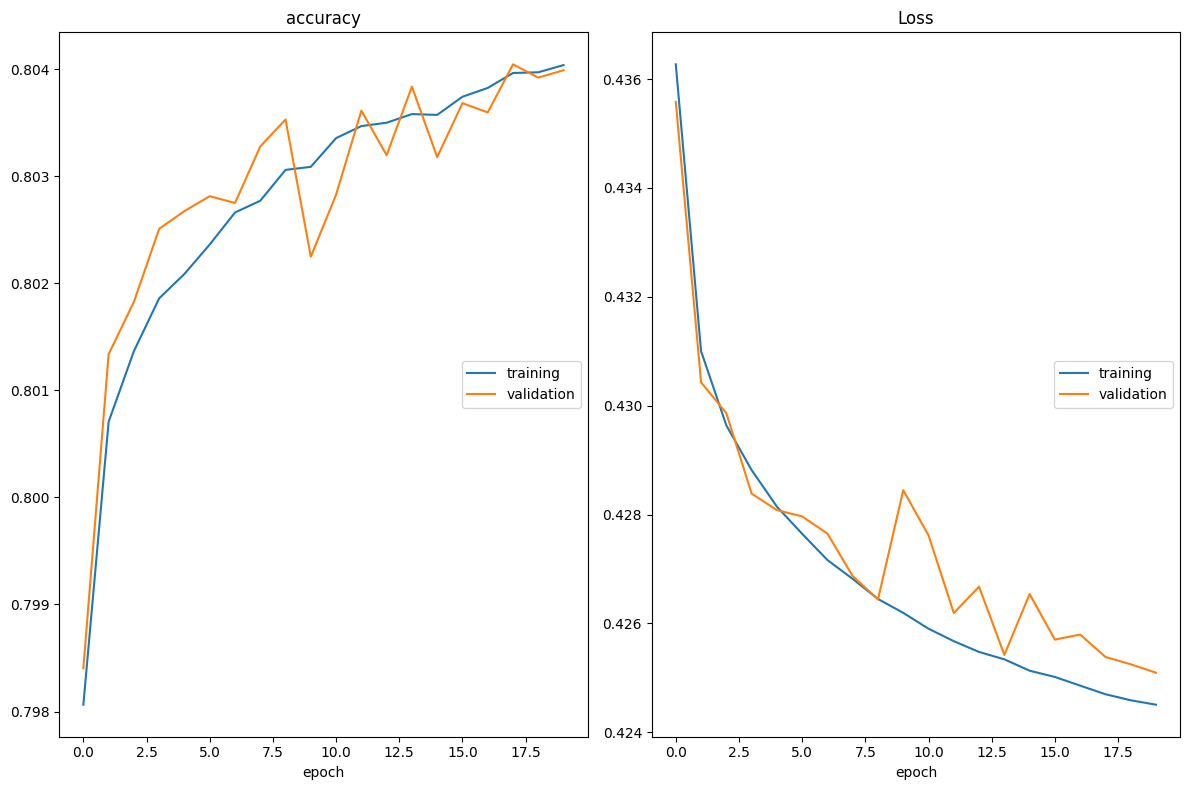

accuracy
	training         	 (min:    0.798, max:    0.804, cur:    0.804)
	validation       	 (min:    0.798, max:    0.804, cur:    0.804)
Loss
	training         	 (min:    0.425, max:    0.436, cur:    0.425)
	validation       	 (min:    0.425, max:    0.436, cur:    0.425)


In [36]:
upscaled_logs = train_model(batch_size, n_epochs, learningRate, 
            upscaledModel, cost_function, optimizer, -1, 
            train_loader, val_loader, name = "upscaled-SUSY");

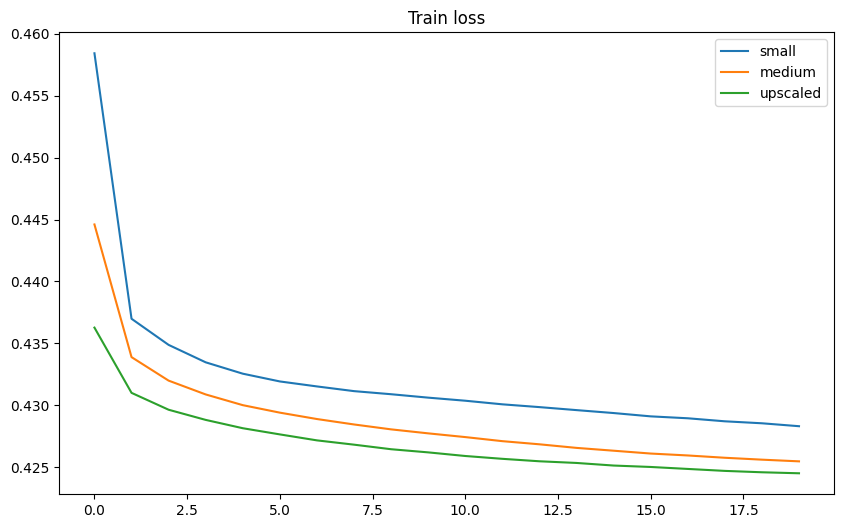

In [37]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10,6))

plt.plot(small_logs['loss'])
plt.plot(medium_logs['loss'])
plt.plot(upscaled_logs['loss'])

plt.legend(['small', 'medium','upscaled'])
plt.title("Train loss")

plt.show()

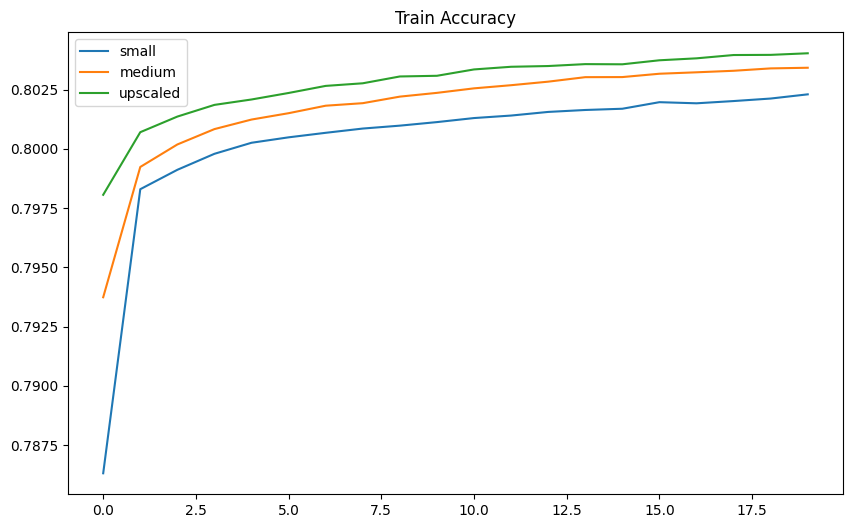

In [38]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10,6))

plt.plot(small_logs['accuracy'])
plt.plot(medium_logs['accuracy'])
plt.plot(upscaled_logs['accuracy'])

plt.legend(['small', 'medium','upscaled'])
plt.title("Train Accuracy")
plt.show()

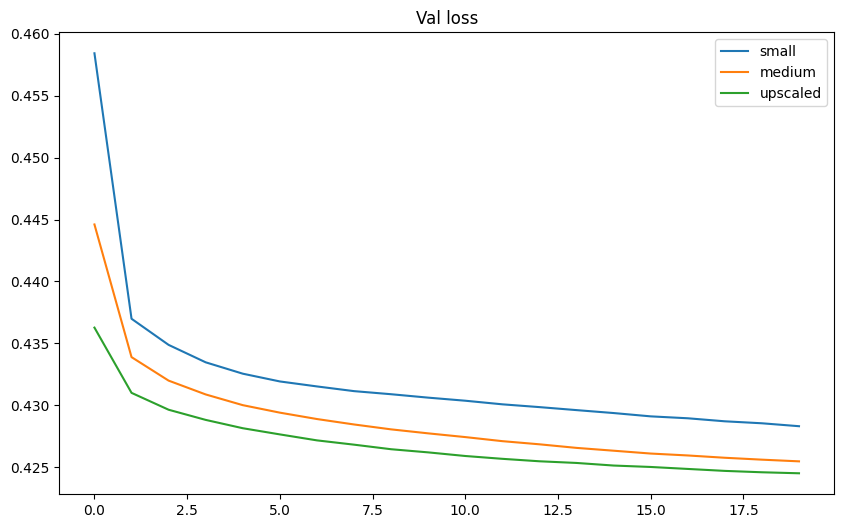

In [39]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10,6))

plt.plot(small_logs['val_loss'])
plt.plot(medium_logs['val_loss'])
plt.plot(upscaled_logs['val_loss'])

plt.legend(['small', 'medium','upscaled'])
plt.title("Val loss")

plt.show()

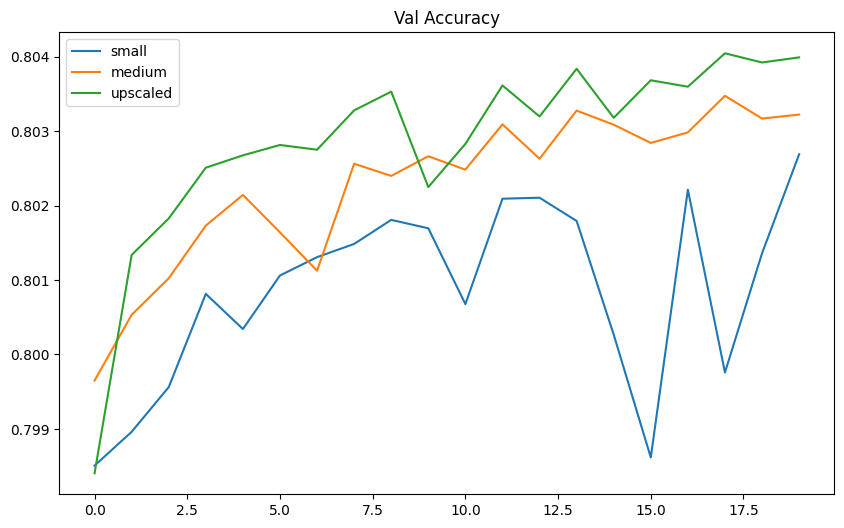

In [40]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10,6))

plt.plot(small_logs['val_accuracy'])
plt.plot(medium_logs['val_accuracy'])
plt.plot(upscaled_logs['val_accuracy'])

plt.legend(['small', 'medium','upscaled'])
plt.title("Val Accuracy")
plt.show()